# 1: [50 pts] Allowed libraries: seaborn, matplotlib, pandas, sklearn

Part a) [10 pts] Normalize the numerical variables, encode the categorical variables (you can use label encoding, or one-hot encoding for categorical variables:https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159 )Identify outliers and remove them from the dataset. The training data contains outliers that are defined as samples that are far from the others. With outlier detection, the goal is to fit the regions where the training data is the most concentrated, ignoring the deviant observations. Use any two outlier detection algorithms (e.g. one-class SVM, LOF, Isolation Forest, etc.) and perform at least two of the methods to the churn dataset. (https://scikit-learn.org/stable/modules/svm.html)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import math
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None 


df = pd.read_csv('../datasets/churn.txt')

# drop categorical columns before finding outliers  
df_dropped = df.drop(df.columns[[0, 2, 3, 4, 5, 20]], axis=1)

# SPLIT the data for the df_dropped data set (70:30)
# only the train data is needed for finding outliers
df_dropped_train = df_dropped.head(math.floor(df_dropped.shape[0]*0.7))

# manage OUTLIERS only on the training set with the dropped columns
detector1 = OneClassSVM(nu = 0.10)
detector2 = LocalOutlierFactor(n_jobs=-1)
detector3 = EllipticEnvelope()
predicted1 = detector1.fit_predict(df_dropped_train)
predicted2 = detector2.fit_predict(df_dropped_train)
predicted3 = detector3.fit_predict(df_dropped_train)
print("SVM: ")
print(pd.crosstab(predicted1, columns=['count']))
print("Local Outlier Factor: ")
print(pd.crosstab(predicted2, columns=['count']))
print("Elliptic Envelope: ")
print(pd.crosstab(predicted3, columns=['count']))

# find the intersection SVM vs EE
svm_out = np.where(predicted1 == -1)
ee_out = np.where(predicted3 == -1)
svm_vs_ee = np.intersect1d(svm_out, ee_out)
print("SVM vs EE: ")
print(f"Size of intersection: {len(svm_vs_ee)}" )

# find the intersection LOF vs SVM+EE
svm_ee = np.append(svm_out, ee_out)   # SVM+EE
svm_ee = np.unique(svm_ee)
lof_out = np.where(predicted2 == -1)    #LOF
lof_vs_svm_ee = np.intersect1d(lof_out, svm_ee)
print("LOF vs SVM+EE: ")
print(f"Size of intersection: {len(lof_vs_svm_ee)}" )

# get the total unique locations of the outliers
outliers = np.append(svm_vs_ee, lof_vs_svm_ee)
outliers = np.unique(outliers)
print("SVM vs EE and LOF vs SVM+EE: ")
print(f"Size of unique outliers: {len(outliers)}" )

# SPLIT the data for the main df (70:30)
df_train = df.head(math.floor(df.shape[0]*0.7))
df_test = df.tail(df.shape[0] - df_train.shape[0])

# delete rows with outliers from df_train
df_train_clean = df_train
print(f"Size before dropping outlier(s): {len(df_train_clean)}")
df_train_clean = df_train.drop(outliers)
df_train_clean = df_train_clean.reset_index()
del df_train_clean['index']
print(f"Size after dropping outlier(s): {len(df_train_clean)}")

# change Area Code data type to category
print("Area Code data type:", df.dtypes['Area Code'])
df_train_clean = df_train_clean.astype({'Area Code': 'category'})
df_test = df_test.astype({'Area Code': 'category'})

# apply LABEL ENCODING to State and Area Code
labelencoder = LabelEncoder()
df_train_clean['State'] = labelencoder.fit_transform(df_train_clean['State'])
df_train_clean['Area Code'] = labelencoder.fit_transform(df_train_clean['Area Code'])
df_test['State'] = labelencoder.fit_transform(df_test['State'])
df_test['Area Code'] = labelencoder.fit_transform(df_test['Area Code'])

# NORMALIZE the numerical variables
# normalize train data
scaler = MinMaxScaler() 
df_train_clean[["State", "Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins", "Night Calls", "Night Charge", "Intl Mins", "Intl Calls", "Intl Charge", "CustServ Calls"]] = scaler.fit_transform(df_train_clean[["State", "Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins", "Night Calls", "Night Charge", "Intl Mins", "Intl Calls", "Intl Charge", "CustServ Calls"]])

# normalize testing data
df_test.loc[:, ["State", "Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins", "Night Calls", "Night Charge", "Intl Mins", "Intl Calls", "Intl Charge", "CustServ Calls"]] = scaler.fit_transform(df_test.loc[:, ["State", "Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins", "Night Calls", "Night Charge", "Intl Mins", "Intl Calls", "Intl Charge", "CustServ Calls"]])

# apply ONE-HOT-ENCODING on Int'l Plan, VMail Plan and Churn?
# it's essentially applying labeling again, at the end there will be binaries only
df_train_clean['Int\'l Plan'] = labelencoder.fit_transform(df_train_clean['Int\'l Plan'])
df_train_clean['VMail Plan'] = labelencoder.fit_transform(df_train_clean['VMail Plan'])
df_train_clean['Churn?'] = labelencoder.fit_transform(df_train_clean['Churn?'])

df_test['Int\'l Plan'] = labelencoder.fit_transform(df_test['Int\'l Plan'])
df_test['VMail Plan'] = labelencoder.fit_transform(df_test['VMail Plan'])
df_test['Churn?'] = labelencoder.fit_transform(df_test['Churn?'])

# I do not use get_dummies method to accomplish one-hot-encoding to avoid multiple additional columns

# DATA SET IS READY
df_train_clean



SVM: 
col_0  count
row_0       
-1       234
 1      2099
Local Outlier Factor: 
col_0  count
row_0       
-1         8
 1      2325
Elliptic Envelope: 
col_0  count
row_0       
-1       234
 1      2099
SVM vs EE: 
Size of intersection: 92
LOF vs SVM+EE: 
Size of intersection: 8
SVM vs EE and LOF vs SVM+EE: 
Size of unique outliers: 93
Size before dropping outlier(s): 2333
Size after dropping outlier(s): 2240
Area Code data type: int64


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,0.32,0.549784,0.5,382-4657,0,1,0.490196,0.781497,0.592593,0.781575,...,0.477273,0.501142,0.602157,0.395161,0.601864,0.500,0.157895,0.500000,0.111111,0
1,0.70,0.458874,0.5,371-7191,0,1,0.509804,0.454689,0.688889,0.454681,...,0.507576,0.495053,0.631216,0.491935,0.631158,0.685,0.157895,0.685185,0.111111,0
2,0.62,0.588745,0.5,358-1921,0,0,0.000000,0.712978,0.622222,0.713039,...,0.560606,0.254566,0.356201,0.500000,0.356192,0.610,0.263158,0.609259,0.000000,0
3,0.70,0.359307,0.0,375-9999,1,0,0.000000,0.889801,0.303704,0.889859,...,0.393939,0.062785,0.458957,0.379032,0.458722,0.330,0.368421,0.329630,0.222222,0
4,0.72,0.320346,0.5,330-6626,1,0,0.000000,0.470793,0.614815,0.470840,...,0.651515,0.342466,0.428999,0.637097,0.428762,0.505,0.157895,0.505556,0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.68,0.350649,0.5,356-5475,0,0,0.000000,0.472056,0.348148,0.472140,...,0.325758,0.288813,0.430497,0.451613,0.430093,0.470,0.052632,0.470370,0.666667,1
2236,0.34,0.523810,0.5,363-9969,0,0,0.000000,0.475845,0.488889,0.475854,...,0.416667,0.146119,0.609646,0.362903,0.609188,0.420,0.315789,0.420370,0.111111,0
2237,0.02,0.588745,0.5,350-4367,0,0,0.000000,0.275024,0.629630,0.275074,...,0.818182,0.670472,0.445177,0.459677,0.444740,0.445,0.105263,0.444444,0.111111,0
2238,0.30,0.294372,1.0,348-1592,0,0,0.000000,0.371961,0.525926,0.372028,...,0.666667,0.632801,0.455063,0.483871,0.454727,0.530,0.105263,0.529630,0.111111,0


## Part b) [15 pts]  Answer the following questions:

### (b-1) [5 pts] are there any outliers on the dataset?
Yes! There are outliers on the dataset

### (b-2) [5 pts] do the methods agree on the detected outliers and why?
The methods partially agree on the detected outliers. Each method finds different set of outliers. 

### (b-3) [5 pts] what are the assumptions behind each method? Remove any outliers (using a single method) and then continue with this new, revised dataset.

The assumption behind the Support Vector Machines method is that the data should be independent and identically distributed.
The assumption behind the Local Outlier Factor method that it considers the density of the neighborhood. It also works better if the density of the data changes throughout the dataset. 
The assumption behind the Eliptic Envelope method is that the data should be normally distributed for good results because this method easily finds outliers located outside the elipse drawn around data points which represent some criteria. 

## Part c) [10 pt] 

Plot a correlation matrix to identify the correlated variables in the revised churn dataset obtained from part b) (https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07) and use seaborn library. Given that correlated features don't improve models, deal with the highly correlated variables by removing correlated features i.e., if you have two features that are highly correlated, you need to remove one. The reason for removing correlated features is to make the algorithm faster because less features means higher speed. Furthermore, removing highly correlated features decreases harmful bias in the final model.

,State,Account Length,Area Code,Int'l Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Mins,Night Calls,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,0.32,0.549784,0.5,0,0.490196,0.592593,0.781575,0.477273,0.501142,0.602157,0.395161,0.157895,0.500000,0.111111,0
1,0.70,0.458874,0.5,0,0.509804,0.688889,0.454681,0.507576,0.495053,0.631216,0.491935,0.157895,0.685185,0.111111,0
2,0.62,0.588745,0.5,0,0.000000,0.622222,0.713039,0.560606,0.254566,0.356201,0.500000,0.263158,0.609259,0.000000,0
3,0.70,0.359307,0.0,1,0.000000,0.303704,0.889859,0.393939,0.062785,0.458957,0.379032,0.368421,0.329630,0.222222,0
4,0.72,0.320346,0.5,1,0.000000,0.614815,0.470840,0.651515,0.342466,0.428999,0.637097,0.157895,0.505556,0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.68,0.350649,0.5,0,0.000000,0.348148,0.472140,0.325758,0.288813,0.430497,0.451613,0.052632,0.470370,0.666667,1
2236,0.34,0.523810,0.5,0,0.000000,0.488889,0.475854,0.416667,0.146119,0.609646,0.362903,0.315789,0.420370,0.111111,0
2237,0.02,0.588745,0.5,0,0.000000,0.629630,0.275074,0.818182,0.670472,0.445177,0.459677,0.105263,0.444444,0.111111,0
2238,0.30,0.294372,1.0,0,0.000000,0.525926,0.372028,0.666667,0.632801,0.455063,0.483871,0.105263,0.529630,0.111111,0


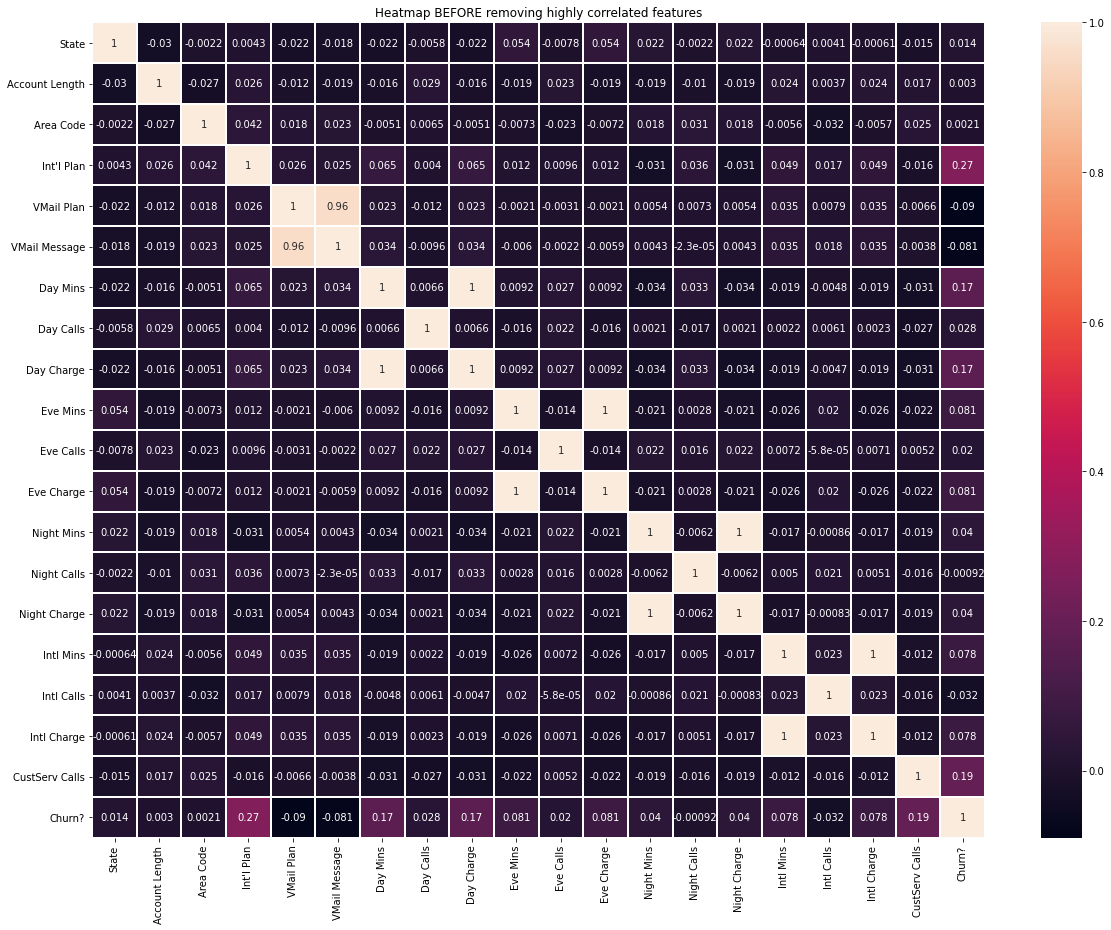

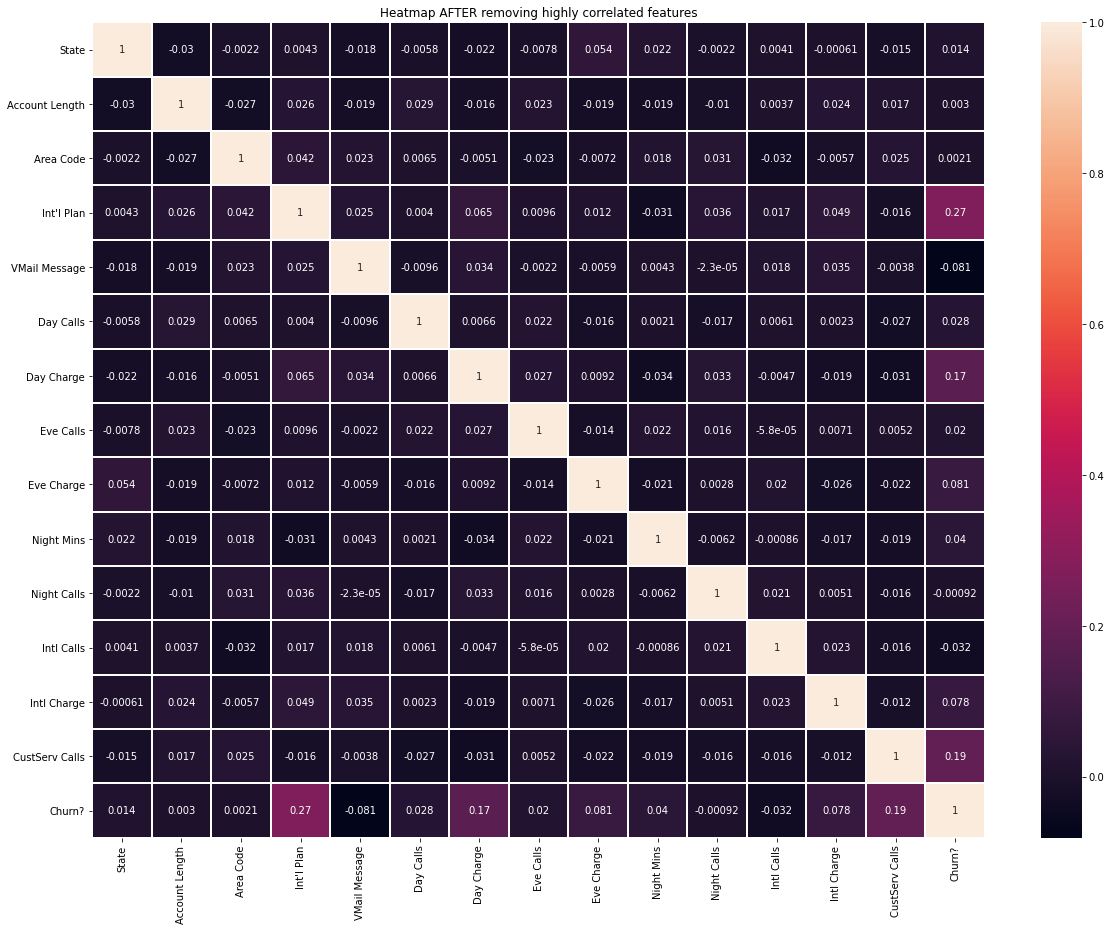

In [9]:
import seaborn as sns
plt.subplots(figsize=(20,15))
heat = sns.heatmap(df_train_clean.corr(), annot=True, linewidths=2)
heat.set_title("Heatmap BEFORE removing highly correlated features")

# there are features that are highly correlated with other features. These are:
# VMail Plan - VMail Message
# Day Mins - Day Charge
# Eve Mins - Eve Charge
# Night Mins - Night Charge
# Intl Mins - Intl Charge
# I will delete one from each pair. It will make the algorithm faster because less features means higher speed. Furthermore, removing highly correlated features decreases harmful bias in the final model.
# Int'l Plan and VMail Plan are binary features. I will delete VMail Plan because it is less corelated with {Churn?} target variable and it is highly correlated with Day Charge
# TO-DELETE: VMail Plan, Day Mins, Eve Mins, Night Charge, Intl Mins, Phone

df_train_clean = df_train_clean.drop(df_train_clean.columns[[3, 5, 7, 10, 15, 16]], axis=1)
df_test = df_test.drop(df_test.columns[[3, 5, 7, 10, 15, 16]], axis=1)
plt.subplots(figsize=(20,15))
heat = sns.heatmap(df_train_clean.corr(), annot=True, linewidths=2)
heat.set_title("Heatmap AFTER removing highly correlated features")

df_train_clean



# 2: [30 pts] Allowed libraries: sklearn, pandas, Keras  and Tensorflow. Report (code and results)

https://keras.io/api/layers/activations/ (Ссылки на внешний сайт.)

## Part a) [15 pts] 
Use the preprocessed churn dataset from Q1 to create a 4-layer artificial neural network (ANN) and specifically a feed-forwardmultilayer perceptron (with sigmoid activations and MSE loss function) to perform multi-class classification to classify 'Churn' based on other variables and describe the topology of the model (how many layers, how many neurons at each layer).

The variables of the datset are explained in the link provided above. Use the 70:30 data split and use the training set for training the model and the test set to evaluate the model performance. Please note that this is a binary classification problem so select the right number of nodes accordingly for the output layer. Also report precision and recall for the test set. 

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

class FitCallBack(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        weights.append(self.model.layers[2].get_weights()[0])

# create a func for a generalized creation of model
def create_model(layer):
    model = keras.Sequential()
    for i, nodes in enumerate(layer):
        if i==0:
            model.add(layers.Dense(nodes, input_dim=df_train_clean.drop('Churn?', axis=1).shape[1], activation='sigmoid'))
        else:
            model.add(layers.Dense(nodes, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid')) # last output layer; no activation needed
    model.compile( loss='mse', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(name="precision" , thresholds=0.5)])
    return model

# use Grid Search [5,10],[10,10],[15,10],[10,15],[15,15],[20,15],[15,20],[20,20]
#layers_arr = [[5,5],[10,5]]
#batch_size_arr = [8,16]
#epochs_arr = [20,40]
#params = dict(layer=layers_arr, batch_size=batch_size_arr, epochs=epochs_arr)
#grid_search = GridSearchCV(estimator=model, param_grid=params)

#grid_search_result = grid_search.fit(X_train, Y_train)
#[grid_search_result.best_score_, grid_search_result.best_params_]

# COULDN'T FIGURE GRID SEARCH OUT

# the actual model
# using 20 neurons in the second layer, 15 neurons in the third layer and 1 neuron for the output layer
weights = []
model = create_model([20,15])
result = model.fit(df_train_clean.drop('Churn?', axis=1), df_train_clean['Churn?'],  validation_split=0.33, epochs=500, batch_size=16, verbose=0, callbacks=[FitCallBack()])

# Precision and recall for training and test data
y_predicted = (model.predict(df_train_clean.drop('Churn?', axis=1))> 0.5).astype("int32")
print("TRAINING data:\nPrecision: ", precision_score(df_train_clean['Churn?'], y_predicted, average='macro', zero_division=0))
print("Recall: ", recall_score(df_train_clean['Churn?'], y_predicted, average='macro', zero_division=0))

y_predicted = (model.predict(df_test.drop('Churn?', axis=1))> 0.5).astype("int32")
print("TEST data:\nPrecision: ", precision_score(df_test['Churn?'], y_predicted, average='macro', zero_division=0))
print("Recall: ", recall_score(df_test['Churn?'], y_predicted, average='macro', zero_division=0))



TRAINING data:
Precision:  0.885875582674733
Recall:  0.6965959328028294
TEST data:
Precision:  0.8642344497607655
Recall:  0.6821288958195373


## Part b) [15 pts] 
Provide two plots: 1)the weight values (only bias) per iteration for the last layer, 2) training and test error per iteration. Use stochastic gradient descent with back-propagation. When reporting error, use the ratio of misclassified samples.

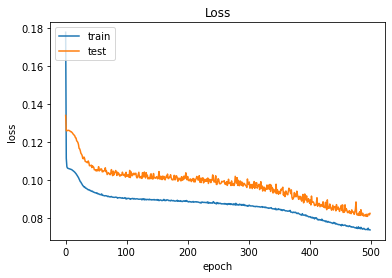

In [11]:
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



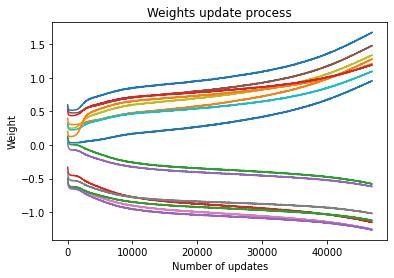

In [12]:
weights_np = np.array(weights, dtype='float32')
weights_np = np.transpose(weights_np)
weights_np = weights_np.reshape([15, 47000])
x = np.linspace(0,len(weights),len(weights))
for epoch in hui2:
    plt.plot(x, epoch.T)
plt.title("Weights update process")
plt.xlabel("Number of updates")
plt.ylabel("Weight")
plt.show()

# 3: [20 pts] 
Now re-train the ANN with all your data (all samples). What is your training error? 

SVM: 
col_0  count
row_0       
-1       333
 1      3000
Local Outlier Factor: 
col_0  count
row_0       
-1        15
 1      3318
Elliptic Envelope: 
col_0  count
row_0       
-1       334
 1      2999
SVM vs EE: 
Size of intersection: 129
LOF vs SVM+EE: 
Size of intersection: 15
SVM vs EE and LOF vs SVM+EE: 
Size of unique outliers: 131
Size before dropping outlier(s): 3333
Size after dropping outlier(s): 3202
Area Code data type: int64
TRAINING data:
Precision:  0.8972659939641072
Recall:  0.7240433298010126


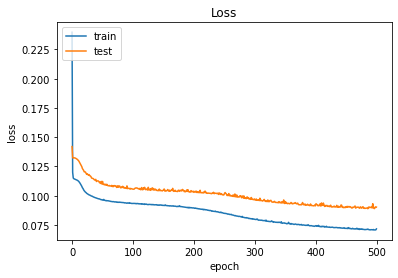

In [13]:
df = pd.read_csv('../datasets/churn.txt')

# drop categorical columns before finding outliers  
df_dropped = df.drop(df.columns[[0, 2, 3, 4, 5, 20]], axis=1)

# manage OUTLIERS only on the training set with the dropped columns
detector1 = OneClassSVM(nu = 0.10)
detector2 = LocalOutlierFactor(n_jobs=-1)
detector3 = EllipticEnvelope()
predicted1 = detector1.fit_predict(df_dropped)
predicted2 = detector2.fit_predict(df_dropped)
predicted3 = detector3.fit_predict(df_dropped)
print("SVM: ")
print(pd.crosstab(predicted1, columns=['count']))
print("Local Outlier Factor: ")
print(pd.crosstab(predicted2, columns=['count']))
print("Elliptic Envelope: ")
print(pd.crosstab(predicted3, columns=['count']))

# find the intersection SVM vs EE
svm_out = np.where(predicted1 == -1)
ee_out = np.where(predicted3 == -1)
svm_vs_ee = np.intersect1d(svm_out, ee_out)
print("SVM vs EE: ")
print(f"Size of intersection: {len(svm_vs_ee)}" )

# find the intersection LOF vs SVM+EE
svm_ee = np.append(svm_out, ee_out)   # SVM+EE
svm_ee = np.unique(svm_ee)
lof_out = np.where(predicted2 == -1)    #LOF
lof_vs_svm_ee = np.intersect1d(lof_out, svm_ee)
print("LOF vs SVM+EE: ")
print(f"Size of intersection: {len(lof_vs_svm_ee)}" )

# get the total unique locations of the outliers
outliers = np.append(svm_vs_ee, lof_vs_svm_ee)
outliers = np.unique(outliers)
print("SVM vs EE and LOF vs SVM+EE: ")
print(f"Size of unique outliers: {len(outliers)}" )

# delete rows with outliers from df
print(f"Size before dropping outlier(s): {len(df)}")
df = df.drop(outliers)
df = df.reset_index()
del df['index']
print(f"Size after dropping outlier(s): {len(df)}")

# change Area Code data type to category
print("Area Code data type:", df.dtypes['Area Code'])
df = df.astype({'Area Code': 'category'})

# apply LABEL ENCODING to State and Area Code
labelencoder = LabelEncoder()
df['State'] = labelencoder.fit_transform(df['State'])
df['Area Code'] = labelencoder.fit_transform(df['Area Code'])

# NORMALIZE the numerical variables
# normalize train data
scaler = MinMaxScaler() 
df[["State", "Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins", "Night Calls", "Night Charge", "Intl Mins", "Intl Calls", "Intl Charge", "CustServ Calls"]] = scaler.fit_transform(df[["State", "Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins", "Night Calls", "Night Charge", "Intl Mins", "Intl Calls", "Intl Charge", "CustServ Calls"]])

# apply ONE-HOT-ENCODING on Int'l Plan, VMail Plan and Churn?
# it's essentially applying labeling again, at the end there will be binaries only
df['Int\'l Plan'] = labelencoder.fit_transform(df['Int\'l Plan'])
df['VMail Plan'] = labelencoder.fit_transform(df['VMail Plan'])
df['Churn?'] = labelencoder.fit_transform(df['Churn?'])

# I do not use get_dummies method to accomplish one-hot-encoding to avoid multiple additional columns

# TO-DELETE: VMail Plan, Day Mins, Eve Mins, Night Charge, Intl Mins, Phone

df = df.drop(df.columns[[3, 5, 7, 10, 15, 16]], axis=1)

# DATA SET IS READY
df.head()

model = create_model([20,15])
result = model.fit(df.drop('Churn?', axis=1), df['Churn?'],  validation_split=0.33, epochs=500, batch_size=16, verbose=0, callbacks=[FitCallBack()])

# Precision and recall for training data
y_predicted = (model.predict(df.drop('Churn?', axis=1))> 0.5).astype("int32")
print("TRAINING data:\nPrecision: ", precision_score(df['Churn?'], y_predicted, average='macro', zero_division=0))
print("Recall: ", recall_score(df['Churn?'], y_predicted, average='macro', zero_division=0))

# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
